<a href="https://colab.research.google.com/github/neuroqudit/pyngn/blob/main/notebooks/03_homeostasis_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. Homeostasis and Stability (Astrocytes)

This notebook demonstrates how Astrocytes regulate the gain of neurons to maintain a target firing rate.

## Astrocyte Dynamics (Homeostasis)

Astrocytes regulate gain $\gamma_i$ based on calcium integration to maintain the reservoir at the "Edge of Chaos".

### Calcium Integration
$$ \tau_{Ca} \frac{dc_i(t)}{dt} = -c_i(t) + s_i(t) $$

### Gain Control
$$ \gamma_i(t+1) = \gamma_i(t) + \eta_{astro} \cdot (\rho_{target} - c_i(t)) $$
If activity is low ($c < \rho$), gain increases. If high, gain decreases.

In [ ]:
!pip install pyngn

In [2]:
import torch
import matplotlib.pyplot as plt
from pyngn.glia import AstrocyteController

%matplotlib inline

## Setup Controller

We simulate a single neuron's astrocyte controller. We will manually feed it spikes to see how the gain evolves.

In [3]:
n_neurons = 1
target_rate = 0.5 # We want the neuron to be active 50% of the time (high for demo)
astro = AstrocyteController(n_neurons, target_rate=target_rate, eta_astro=0.05, beta_ca=0.9)

gain_trace = []
calcium_trace = []
input_spikes = []

# Phase 1: No activity (Gain should rise)
for _ in range(50):
    s = torch.tensor([0.0])
    gamma = astro.update(s)

    gain_trace.append(gamma.item())
    calcium_trace.append(astro.calcium.item())
    input_spikes.append(0)

# Phase 2: High activity (Gain should fall)
for _ in range(50):
    s = torch.tensor([1.0])
    gamma = astro.update(s)

    gain_trace.append(gamma.item())
    calcium_trace.append(astro.calcium.item())
    input_spikes.append(1)

# Phase 3: Target activity (Gain should stabilize?)
# Alternating 0 and 1 is 0.5 rate
for i in range(100):
    s = torch.tensor([float(i % 2)])
    gamma = astro.update(s)

    gain_trace.append(gamma.item())
    calcium_trace.append(astro.calcium.item())
    input_spikes.append(s.item())

## Visualization

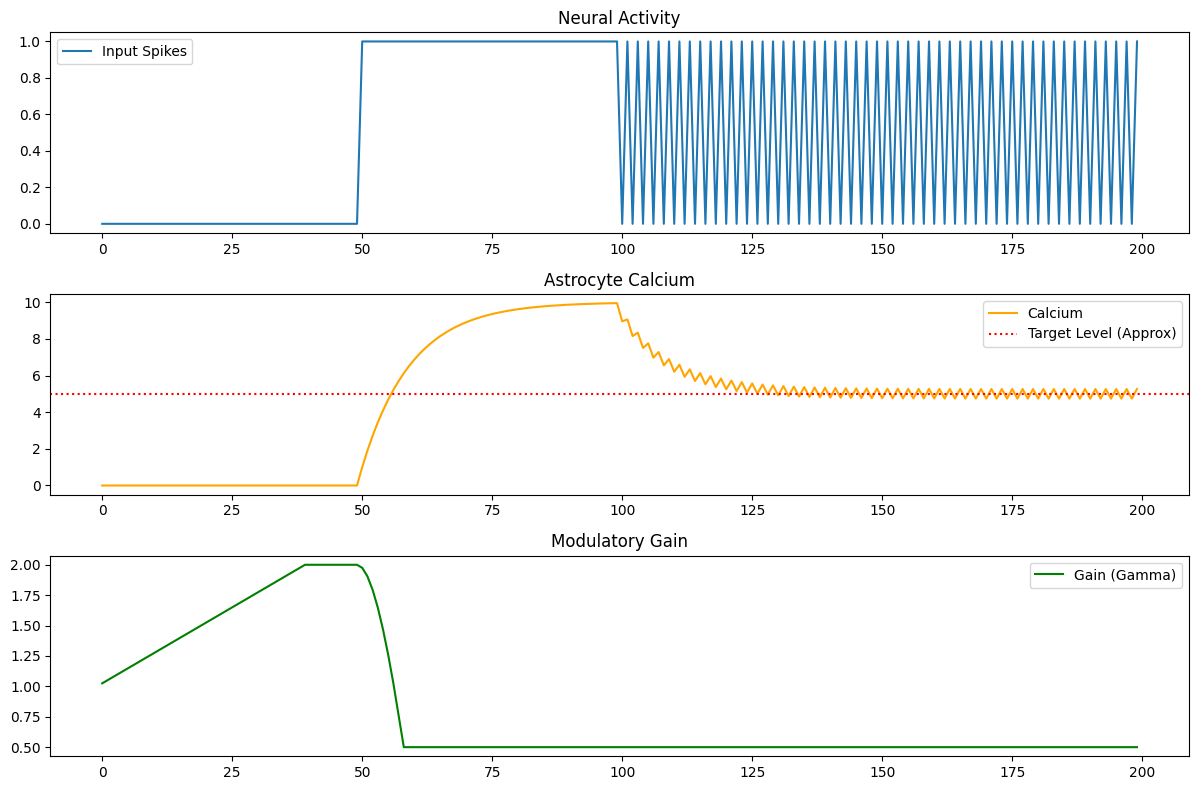

In [4]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(input_spikes, label='Input Spikes')
plt.title('Neural Activity')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(calcium_trace, color='orange', label='Calcium')
plt.axhline(target_rate / (1 - 0.9), color='r', linestyle=':', label='Target Level (Approx)')
# Note: With beta=0.9, steady state Ca for input 1 is 1/(1-0.9)=10.
# For input 0.5, it is 5.
# The controller compares Ca to target_rate (0.5).
# Wait, if target_rate is 0.5 (raw spikes), but Ca accumulates to ~5,
# then Ca will always be > target_rate if active.
# The target_rate in the formula should probably be the TARGET CALCIUM level,
# or Ca should be a running average (rate) not accumulation.
# In the code: Ca = 0.9*Ca + s.
# If s=0.5 avg, Ca -> 5.
# If target_rate=0.5, then 0.5 - 5 = -4.5 -> Gain crashes.
# So either target_rate should be scaled, or Ca should be (1-beta)*Ca + beta*s.
# Let's check the code implementation vs intent.
plt.legend()
plt.title('Astrocyte Calcium')

plt.subplot(3, 1, 3)
plt.plot(gain_trace, color='green', label='Gain (Gamma)')
plt.title('Modulatory Gain')
plt.legend()

plt.tight_layout()
plt.show()